In [2]:
import jax
import jax.numpy as jnp
from jax import jit, grad, jvp, hessian
import time

In [3]:
import jax
import jax.numpy as jnp
from jax import grad, jvp
import jax.lax

def lanczos_HVP(loss_fn, params, num_iter=100, key=jax.random.PRNGKey(0)):
    grad_fn = grad(loss_fn)  # Precompute gradient function
    
    def hvp(v):
        _, hvp_val = jvp(grad_fn, (params,), (v,))
        return hvp_val

    n = params.shape[0]
    V = jnp.zeros((n, num_iter))
    T = jnp.zeros((num_iter, num_iter))

    # Initialize random unit vector
    v = jax.random.normal(key, (n,))
    v /= jnp.sqrt(jnp.sum(v**2))  
    w = hvp(v)

    alpha = jnp.vdot(v, w)
    w -= alpha * v

    V = V.at[:, 0].set(v)
    T = T.at[0, 0].set(alpha)

    def lanczos_step(j, state):
        V, T, v, w = state

        beta = jnp.sqrt(jnp.sum(w**2))  # More efficient norm calculation
        v_next = w / beta
        w = hvp(v_next)
        w -= beta * v
        alpha = jnp.vdot(v_next, w)
        w -= alpha * v_next

        V = V.at[:, j].set(v_next)
        T = T.at[j, j].set(alpha)
        T = T.at[j, j - 1].set(beta)
        T = T.at[j - 1, j].set(beta)

        return V, T, v_next, w

def lanczos_HVP_SaI(loss_fn, params, sig, num_iter=100, key=jax.random.PRNGKey(0)):
    grad_fn = grad(loss_fn)  # Precompute gradient function
    
    def hvp(v):
        _, hvp_val = jvp(grad_fn, (params,), (v,))
        return hvp_val

    n = params.shape[0]
    V = jnp.zeros((n, num_iter))
    T = jnp.zeros((num_iter, num_iter))

    # Initialize random unit vector
    v = jax.random.normal(key, (n,))
    v /= jnp.sqrt(jnp.sum(v**2))  
    w = hvp(v)
    w = jnp.linalg.inv(w[:, jnp.newaxis]@v[:, jnp.newaxis].T - sig*jnp.eye(n)) @ v
    alpha = jnp.vdot(v, w)
    w -= alpha * v

    V = V.at[:, 0].set(v)
    T = T.at[0, 0].set(alpha)

    def lanczos_step(j, state):
        V, T, v, w = state

        beta = jnp.sqrt(jnp.sum(w**2))  # More efficient norm calculation
        v_next = w / beta
        w = hvp(v_next)
        w = jnp.linalg.inv(w[:, jnp.newaxis]@v[:, jnp.newaxis].T - sig*jnp.eye(n)) @ v
        w -= beta * v
        alpha = jnp.vdot(v_next, w)
        w -= alpha * v_next

        V = V.at[:, j].set(v_next)
        T = T.at[j, j].set(alpha)
        T = T.at[j, j - 1].set(beta)
        T = T.at[j - 1, j].set(beta)

        return V, T, v_next, w

    V, T, v, w = jax.lax.fori_loop(1, num_iter, lanczos_step, (V, T, v, w))

    # Compute eigenvalues and eigenvectors of T
    eigvals, eigvecs_T = jnp.linalg.eigh(T)
    eigvals = 1/eigvals + sig


    # Transform eigenvectors of T back to Hessian space
    eigvecs_H = V @ eigvecs_T
    eigvecs_H /= jnp.sqrt(jnp.sum(eigvecs_H**2, axis=0))  # Normalize

    return eigvals, eigvecs_H

def lanczos(A, num_iter=100, key=jax.random.PRNGKey(0)):

    n = A.shape[0]
    V = jnp.zeros((n, num_iter))
    T = jnp.zeros((num_iter, num_iter))

    # Initialize random unit vector
    v = jax.random.normal(key, (n,))
    v /= jnp.sqrt(jnp.sum(v**2))  
    w = A @ v
    alpha = jnp.vdot(v, w)
    w -= alpha * v

    V = V.at[:, 0].set(v)
    T = T.at[0, 0].set(alpha)

    def lanczos_step(j, state):
        V, T, v, w = state

        beta = jnp.sqrt(jnp.sum(w**2))  # More efficient norm calculation
        v_next = w / beta
        w = A @ v_next - beta * v
        alpha = jnp.vdot(v_next, w)
        w -= alpha * v_next

        V = V.at[:, j].set(v_next)
        T = T.at[j, j].set(alpha)
        T = T.at[j, j - 1].set(beta)
        T = T.at[j - 1, j].set(beta)

        return V, T, v_next, w

    V, T, v, w = jax.lax.fori_loop(1, num_iter, lanczos_step, (V, T, v, w))

    # Compute eigenvalues and eigenvectors of T
    eigvals, eigvecs_T = jnp.linalg.eigh(T)

    # Transform eigenvectors of T back to Hessian space
    eigvecs_H = V @ eigvecs_T
    eigvecs_H /= jnp.sqrt(jnp.sum(eigvecs_H**2, axis=0))  # Normalize

    return eigvals, eigvecs_H

def lanczos_SaI(A, sig, num_iter=100, key=jax.random.PRNGKey(0)):

    n = A.shape[0]
    V = jnp.zeros((n, num_iter))
    T = jnp.zeros((num_iter, num_iter))

    A = jnp.linalg.inv(A-jnp.eye(n)*sig)

    # Initialize random unit vector
    v = jax.random.normal(key, (n,))
    v /= jnp.sqrt(jnp.sum(v**2))  
    w = A @ v
    alpha = jnp.vdot(v, w)
    w -= alpha * v

    V = V.at[:, 0].set(v)
    T = T.at[0, 0].set(alpha)

    def lanczos_step(j, state):
        V, T, v, w = state

        beta = jnp.sqrt(jnp.sum(w**2))  # More efficient norm calculation
        v_next = w / beta
        w = A @ v_next - beta * v
        alpha = jnp.vdot(v_next, w)
        w -= alpha * v_next

        V = V.at[:, j].set(v_next)
        T = T.at[j, j].set(alpha)
        T = T.at[j, j - 1].set(beta)
        T = T.at[j - 1, j].set(beta)

        return V, T, v_next, w

    V, T, v, w = jax.lax.fori_loop(1, num_iter, lanczos_step, (V, T, v, w))

    # Compute eigenvalues and eigenvectors of T
    eigvals, eigvecs_T = jnp.linalg.eigh(T)
    eigvals = 1/eigvals + sig

    # Transform eigenvectors of T back to Hessian space
    eigvecs_H = V @ eigvecs_T
    eigvecs_H /= jnp.sqrt(jnp.sum(eigvecs_H**2, axis=0))  # Normalize

    return eigvals, eigvecs_H

In [ ]:
def get_times(N):
    res = {"full": None,
           "HVP": None,
           "Lanczos": None}
    
    def quadratic_loss(params):
        return 0.5 * jnp.sum(params @ jnp.diag(jnp.arange(1, N+1)) @ params)

    params = jnp.ones(N)

    ts = time.time()
    H_fun = hessian(quadratic_loss)
    H = H_fun(params)
    w, v = jnp.linalg.eigh(H)
    print("actual value:", w[-1])
    print("actual vector:", v[:, -1])
    tf = time.time()
    res["full"] = tf-ts

    ts = time.time()
    eigenvalues, eigenvectors = lanczos_HVP(quadratic_loss, params, num_iter=200)
    print("HVP value:", eigenvalues[-1])
    print("HVP vector:", eigenvectors[:, -1])
    tf = time.time()
    res["HVP"] = tf-ts

    ts = time.time()
    H_fun = hessian(quadratic_loss)
    H = H_fun(params)
    w, v = lanczos(H, 200)
    print("lanczos value:", w[-1])
    print("lanczos vector:", v[:, -1])
    tf = time.time()
    res["Lanczos"] = tf-ts
    return res

In [55]:
res = {}

for n in jnp.arange(1, 5):
    N = 10**n
    print("running N =", N)
    res[int(N)] = get_times(int(N))

running N = 10
actual value: 10.0
actual vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
HVP value: 10.000004
HVP vector: [-1.4845860e-07  1.4424757e-07  1.7533981e-08 -8.1696619e-08
 -4.7463239e-08  1.8364440e-07 -4.3052410e-08  6.5703394e-09
  8.5758856e-08  1.0000000e+00]
lanczos value: 10.000004
lanczos vector: [-1.4845860e-07  1.4424757e-07  1.7533981e-08 -8.1696619e-08
 -4.7463239e-08  1.8364440e-07 -4.3052410e-08  6.5703394e-09
  8.5758856e-08  1.0000000e+00]
running N = 100
actual value: 100.0
actual vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1.]
HVP value: 100.0
HVP vector: [-3.1334451e-08 -4.1501156e-08  3.8907846e-09 -2.8022402e-09
 -1.0898782e-08 -9.7060413e-09  7.5410327e-08  7.6133180e-09
  2.7973737e-08 -1.9601005e-0

In [56]:
full_vals = [val['full'] for val in res.values()]
HVP_vals = [val['HVP'] for val in res.values()]
Lanc_vals = [val['Lanczos'] for val in res.values()]

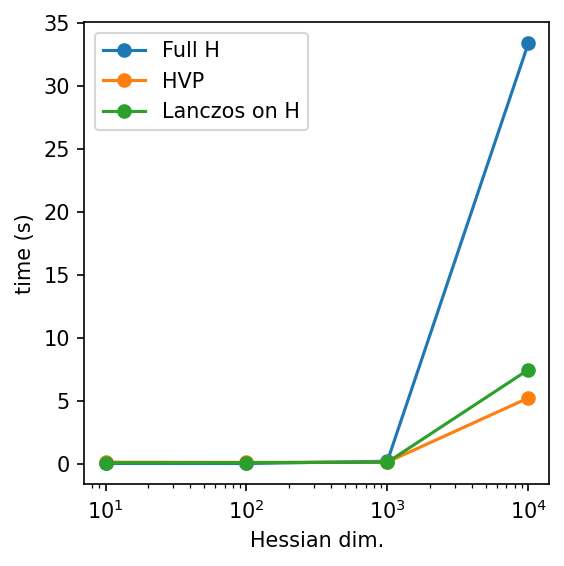

In [57]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
ax.set_xscale("log")
ax.plot(res.keys(), full_vals, "o-", label="Full H")
ax.plot(res.keys(), HVP_vals, "o-", label="HVP")
ax.plot(res.keys(), Lanc_vals, "o-", label="Lanczos on H")
ax.set_ylabel("time (s)")
ax.set_xlabel("Hessian dim.")
plt.legend()
plt.show()

In [4]:
type(jax.random.PRNGKey(0))

jaxlib.xla_extension.ArrayImpl